In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import os 
os.chdir('../')

from python.create_dgl_dataset import TelemacDataset
from python.python_code.data_manip.extraction.telemac_file import TelemacFile

import torch
from tqdm import trange
import copy
import pandas as pd
import random
import dgl

In [2]:
!ls

MPINN_tf		   jupyterlab-9007382.output  mesures_rapport
MPINN_tf_v2		   jupyterlab-9007392.error   miniconda3
PINN_Instationnaire.ipynb  jupyterlab-9007392.output  modulus-launch
PINN_prise_en_main.ipynb   jupyterlab-9007467.error   myproject
best_models		   jupyterlab-9007467.output  neural_operator
bimodel			   jupyterlab-9007468.error   non_diff_model
checkpoints		   jupyterlab-9007468.output  projet-ekip-ia
checkpoints_1		   jupyterlab-9007469.error   regression_classique_stab
checkpoints_10		   jupyterlab-9007469.output  sadok
checkpointsv2		   jupyterlab-9007470.error   seance1.ipynb
deep-ddm		   jupyterlab-9007470.output  telemac-dataset-toy
deep-ddm-sadok		   jupyterlab-9007509.error   telemac-singularity
deep_ddm		   jupyterlab-9007509.output  telemac.sif
deep_ddm_en		   jupyterlab-9007563.error   telemac_bdd_process
env_dgl			   jupyterlab-9007563.output  tensorflow_datasets
first-order-test	   jupyterlab-9007577.error   test.sh
first_order_test	   jupyterlab-9007577.output  

In [3]:
graphs, _ = dgl.load_graphs('./gnn_modulus_project/data/TetQ2500inter_1min_chunk/TetQ2500inter_1min_base.bin') 

In [4]:
print(len(graphs))

1


In [5]:
def has_duplicate_edges(graph):
    src, dst = graph.edges()
    edge_tuples = list(zip(src.numpy(), dst.numpy()))
    unique_edges = set(edge_tuples)
    return len(unique_edges) != len(edge_tuples)

has_duplicate_edges(graphs[0])

False

In [6]:
#J'ai des edges dans les deux sens donc on a une moyenne forcément de 0 

In [7]:
from python.create_dgl_dataset import add_mesh_info
ts = 0
mesh_list = ['/projets/aniti-daml/vmercier/simu_valentin/maillage_3.slf']
one_hot = graphs[ts].ndata['static'][:,:4]
coeff = graphs[ts].ndata['static'][:,4:5]
z = graphs[ts].ndata['static'][:,5:6]
res_mesh = TelemacFile(mesh_list[0])
X,triangles = add_mesh_info(res_mesh)

In [8]:
print(np.mean(X[:,0]))

695774.1753674486


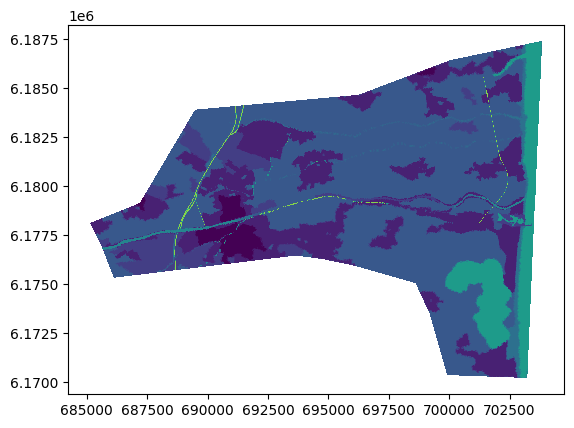

In [9]:
plt.figure()
plt.tripcolor(X[:,0],X[:,1],coeff[:,0],triangles=triangles)
plt.show()

In [11]:
dataset = TelemacDataset(
            name="TetQ2500inter_1min",
            data_dir='./gnn_modulus_project/data/TetQ2500inter_1min_chunk/TetQ2500inter_1min_base.bin',
            dynamic_data_file= './gnn_modulus_project/data/TetQ2500inter_1min_chunk/TetQ2500inter_1min_0_0-500.pkl',
            split="train",
            num_samples=1,
            num_steps=200,
    normalize=False
        )

In [11]:
from python.create_dgl_dataset import NodeType
def plot_mesh_with_node_types(dataset,X, timestep=0):
    """
    Plots the mesh with different colors depending on the node type.
    
    Args:
        dataset (TelemacDataset): The dataset containing the mesh and node data.
        timestep (int): The timestep to visualize. Default is 0.
    """
    # Retrieve the base graph and node features
    g = dataset.base_graph
    static_features = g.ndata['static']
    node_types = static_features[:, :4].numpy()
    
    # Extract the node coordinates
    x_coords = X[:,0]
    y_coords = X[:,1]
    
    # Define colors for different node types
    colors = {
        "NORMAL": "blue",
        "PRESCRIBED_H": "green",
        "PRESCRIBED_Q": "red",
        "WALL_BOUNDARY": "purple"
    }
    
    # Plot the nodes with different colors based on their type
    plt.figure()
    for node_type, color in zip(["NORMAL", "PRESCRIBED_H", "PRESCRIBED_Q", "WALL_BOUNDARY"], colors.values()):
        mask = (node_types[:,NodeType[node_type].value]==1)
        plt.scatter(x_coords[mask], y_coords[mask], c=color, label=node_type, s=10)
    
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title(f"Mesh Node Types at Timestep {timestep}")
    plt.legend()
    plt.show()
    


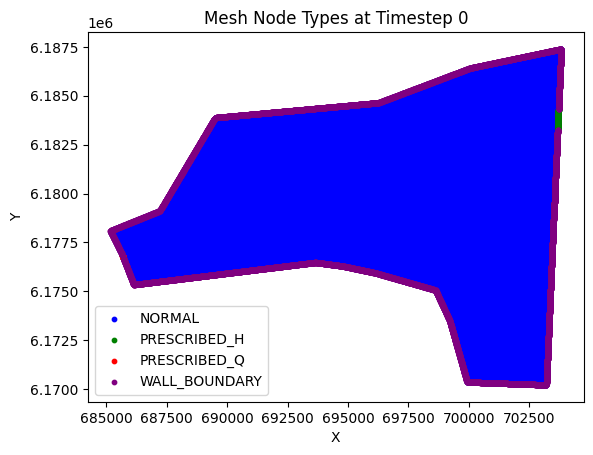

In [12]:
plot_mesh_with_node_types(dataset,X, timestep=0)

torch.Size([412844, 9])
(412844,)
tensor([[0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.]])


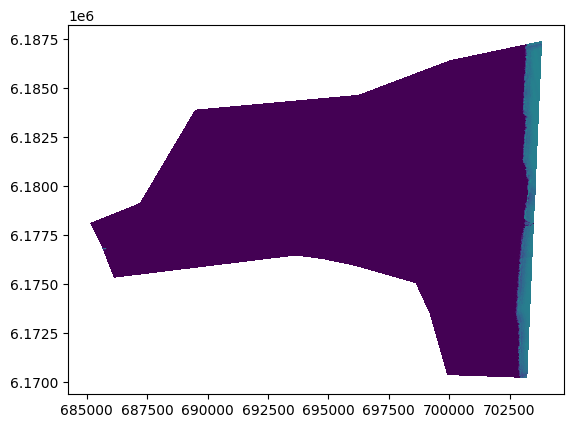

In [13]:
test1 = dataset[0]
test2 = dataset[1]

a=(test1.ndata['x'][:,-3:]+test1.ndata['y'][:,:]).numpy()
b=(test2.ndata['x'][:,-3:]).numpy()
mask = (a!=b).all(axis=1)
print(test1.ndata['x'].shape)
print(mask.shape)
print(test1.ndata['x'][mask,:4])
plt.figure()
plt.tripcolor(X[:,0],X[:,1],a[:,0],triangles=triangles)
plt.show()

In [14]:
import pickle
# Load dynamic data
with open('./gnn_modulus_project/data/TetQ2500inter_1min_chunk/TetQ2500inter_1min_0_0-500.pkl', 'rb') as f:
    dynamic_data_list = pickle.load(f)

In [19]:
x,y = dynamic_data_list[0]
xdt,_ = dynamic_data_list[1]
mask = (x+y != xdt).all(axis=1)
print(test1.ndata['x'][mask,:4])
print(x[mask]-xdt[mask])

tensor([[0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.]])
[[ 0.11599761  0.10928369  0.03435053]
 [-0.01093793  0.07813692  0.02456033]
 [-0.30851972 -0.01005352 -0.00316006]
 [-0.19502926  0.06134355  0.01928177]
 [-0.21397758  0.03290427  0.0103426 ]
 [-0.13488126  0.04264355  0.01340389]
 [-0.14287543  0.02835429  0.00891247]
 [-0.02825868  0.05358869  0.01684421]
 [-0.03260779  0.04527843  0.01423213]
 [ 0.00855005  0.06024623  0.01893687]
 [-0.03200793  0.04534543  0.01425317]
 [ 0.03859401  0.10088646  0.03171107]
 [-0.00812596  0.04290515  0.01348615]
 [ 0.2444626   0.4313195   0.13557425]
 [ 0.0462995   0.06133372  0.01927869]]


In [12]:
import networkx as nx

In [ ]:
def reachable_nodes(g, start_node, x):
    reachable = torch.full((g.num_nodes(),), False, dtype=torch.bool)
    current_frontier = torch.tensor([start_node], dtype=torch.int64)
    reachable[current_frontier] = True

    for _ in range(x + 3):  # Extend to x+3 to accommodate the larger radius
        if _ == x:
            within_x_reachable = reachable.clone()
        current_frontier = g.in_edges(current_frontier)[0]
        reachable[current_frontier] = True
    
    return within_x_reachable, reachable

def extract_and_visualize_subgraph(g, start_node, x):
    # Get nodes reachable within x and x+3 hops
    within_x_reachable, within_x_plus_3_reachable = reachable_nodes(g, start_node, x)

    # Extract subgraph for nodes within x+3 hops
    subgraph = g.subgraph(torch.nonzero(within_x_plus_3_reachable, as_tuple=True)[0])

    # Convert to NetworkX graph for visualization
    nx_g = subgraph.to_networkx().to_undirected()

    # Prepare node colors: red for within x hops, blue for x+1 to x+3 hops
    color_map = []
    for node_id in nx_g.nodes():
        if within_x_reachable[node_id]:
            color_map.append('red')
        else:
            color_map.append('blue')

    # Visualization
    plt.figure(figsize=(10, 10))
    nx.draw(nx_g, node_color=color_map, with_labels=True, node_size=50, font_color='white')
    plt.title(f"Subgraph Visualization within {x} (red) and {x+3} (blue) Hops from Node {start_node}")
    plt.show()


In [ ]:
g = graphs[ts]
input_bd_index = np.where((g.ndata['x'][:,:4].numpy()==[0,0,1,0]).all(axis=1))[0][5]
reachable = reachable_nodes(g, input_bd_index, 4)


In [ ]:
# Convert DGL graph to networkx graph for visualization
nx_g = g.to_networkx().to_undirected()

# Node colors
color_map = ['red' if reachable[i] else 'blue' for i in range(g.num_nodes())]

# Draw the graph using a different method
plt.figure(figsize=(8, 8))
nx.draw_networkx(nx_g, node_color=color_map, with_labels=True, node_size=700, font_color='white')
plt.show()